In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as pl

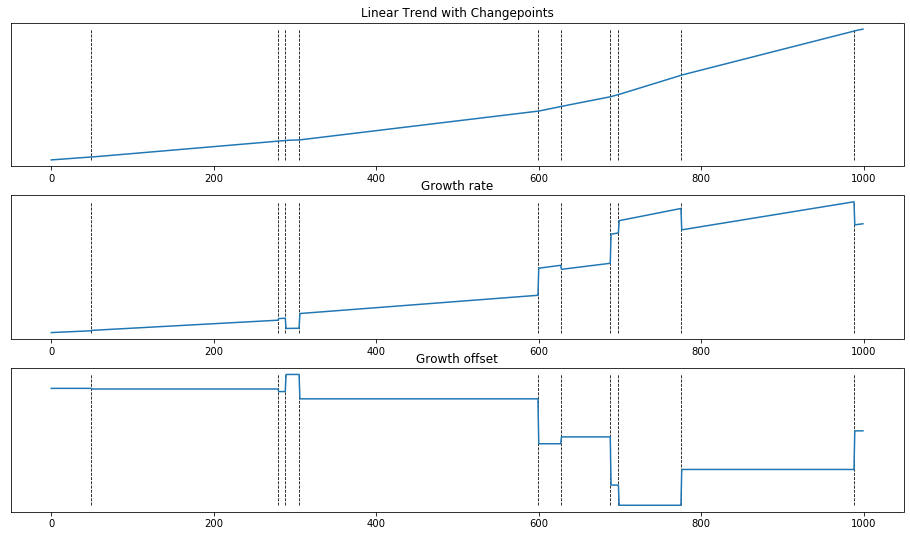

In [9]:
np.random.seed(25)
n_changepoints = 10
t = np.arange(1000)
s = np.sort(np.random.choice(t, n_changepoints, replace=False))

A = (t[:, None] > s) * 1
delta = np.random.normal(size=n_changepoints)
k = 1
m = 5

growth = (k + A @ delta) * t
gamma = -s * delta
offset = m + A @ gamma
trend = growth + offset

pl.figure(figsize=(16, 3 * 3))
n = 310
i = 0
for t, f in zip(['Linear Trend with Changepoints', 'Growth rate', 'Growth offset'],
                [trend, growth, offset]):
    i += 1
    pl.subplot(n + i)
    pl.title(t)
    pl.yticks([])
    pl.vlines(s, min(f), max(f), lw=0.8, linestyles='--')
    pl.plot(f)

In [13]:
np.testing.assert_array_equal(np.dot(A, gamma), A@gamma)

In [3]:
df = pd.read_csv('/accounts/ekarakoy/Downloads/example_wp_log_peyton_manning.csv',
                 parse_dates=['ds']
            )

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
ds    2905 non-null datetime64[ns]
y     2905 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.5 KB


In [15]:
df['y_scaled'] = df['y'] / df.y.max()

In [16]:
df['t'] = (df.ds - df.ds.min()) / (df.ds.max() - df.ds.min())

In [22]:
df.head()

,ds,y,y_scaled,t
0,2007-12-10,9.590761,0.746552,0.000000
1,2007-12-11,8.519590,0.663171,0.000337
2,2007-12-12,8.183677,0.637023,0.000675
3,2007-12-13,8.072467,0.628367,0.001012
4,2007-12-14,7.893572,0.614441,0.001350


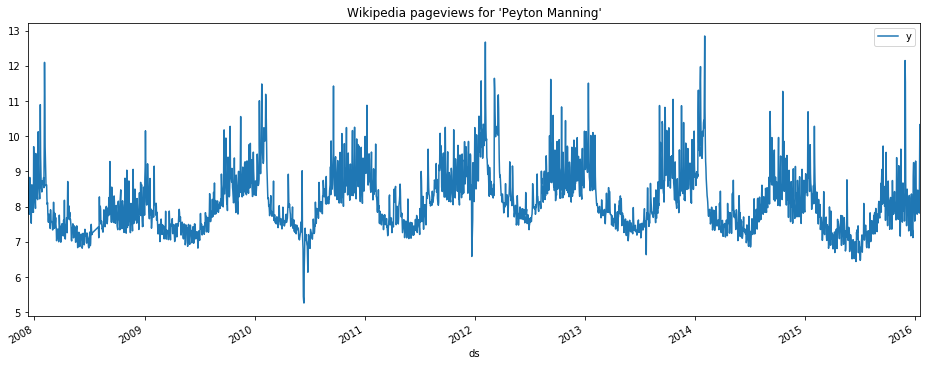

In [18]:
df.plot(x='ds', y='y', figsize=(16, 6),
        title="Wikipedia pageviews for 'Peyton Manning'");

In [19]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + pm.math.dot(A, delta)) * t + (m + pm.math.dot(A, gamma))
    return g, A, s

# Generate a PyMC3 Model context
m = pm.Model()

with m:
    y, A, s = trend_model(m, df['t'])
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])

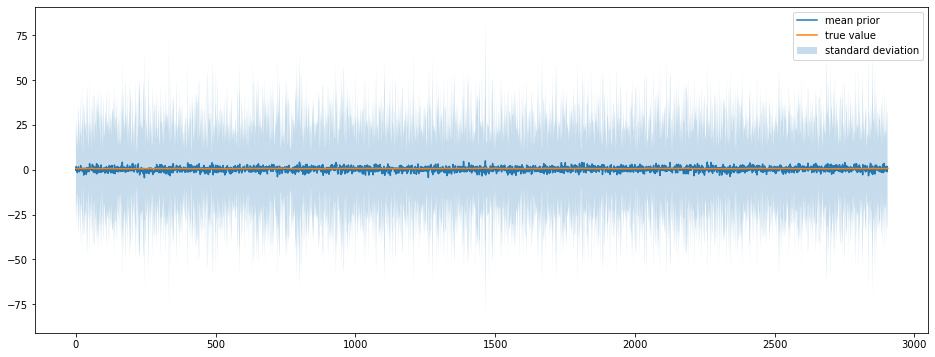

In [20]:
def sanity_check(m, df):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m, vars=['obs'])['obs']
    pl.figure(figsize=(16, 6))
    pl.plot(y.mean(0), label='mean prior')
    pl.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    pl.plot(df['y_scaled'], label='true value')
    pl.legend()

# And run the sanity check
sanity_check(m, df)

/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 4,013.9, ||grad|| = 190.76: 100%|██████████| 145/145 [00:00<00:00, 611.02it/s] 


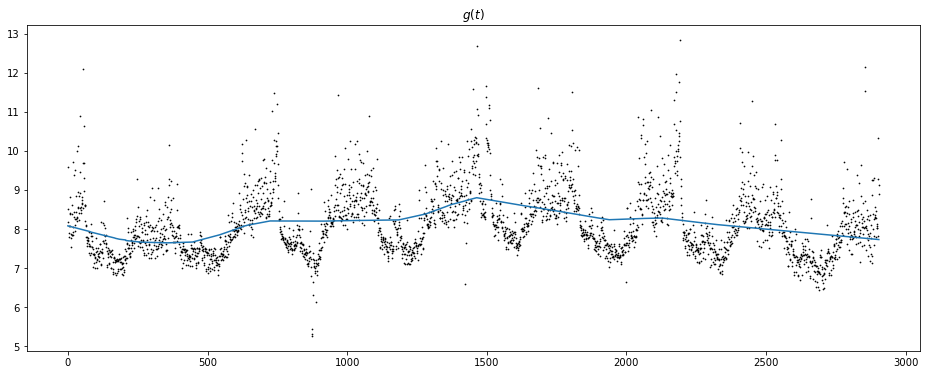

In [21]:
# Find a point estimate of the models parameters
with m:
    aprox = pm.find_MAP()

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g = det_trend(aprox['k'], aprox['m'], aprox['delta'], df['t'], s, A) * df['y'].max()

pl.figure(figsize=(16, 6))
pl.title('$g(t)$')
pl.plot(g)
pl.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')